In [1]:
# Basic
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import pinv2
from tqdm import tqdm

# For Dataset
from collections import deque, namedtuple
import random

# For solvers
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *
import casadi

# For estimators
from torch import nn
import torch
import torch.nn.functional as F




In [2]:
from utils.system import AAC
from utils.controller import *
from utils.dataset import Dataset
from utils.estimator import *
from utils.normalizer import *


In [3]:
def sample_initial_state(p_min = 0, p_max = 2,
                         v_min = 18, v_max = 22,
                         z_min = 38, z_max = 42):
    p0 = np.random.uniform(p_min, p_max)
    v0 = np.random.uniform(v_min, v_max)
    z0 = np.random.uniform(z_min, z_max)
    return [p0, v0, z0] 


class Derivator:
    def __init__(self, dt):
        self.x = 0
        self.dt = dt
        
    def update(self, x_n):
        dx = (x_n - self.x)/dt
        
        self.x = x_n
        
        
        return dx
    

# Parameters

In [4]:
dt = 0.02
simTime = 10

# Real parameters
v_lead = 20
v_des = 24
m  = 1650.0
g = 9.81


# 
f0 = 0.1
f1 = 5
f2 = 0.25


c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0
v0 = 20
z0 = 40

x = [p0, v0 ,z0]

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []


In [5]:
class Dummy:
    def __init__(self):
        self.var = 0

    def forward(self, x, u, t):
        return 0

## Main

In [6]:
def step(t, th = 5, A = 5):    
    return 0 if t > th else A

def square(t, w = 3, A = 5):
    return -A if np.sin(w*t) < 0 else A
    
def sin(t, w = 3, A = 5):
    return A*np.sin(w*t)

In [7]:
d = Dataset(('x', 'k', 'dhe_real'))

aac = AAC(m, c_d, f0, f1, f2, v_lead)

norm_x = WelfordNormalizerOne((3,))
norm_u = WelfordNormalizerOne((1,))
norm_dhe = WelfordNormalizerOne((1,))

normalizer = {'x':norm_x, 'u':norm_u, 'dhe':norm_dhe}


cont = LCBF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_lead, v_des, Th, clf_rate, cbf_rate, p_slack)

estimator = Dummy()# NN_affine(3)
#e_f_opt,e_g_opt = torch.optim.Adam(estimator.e_f.model.parameters(), lr = 5e-1), torch.optim.Adam(estimator.e_g.model.parameters(), lr = 5e-5) 

weights = 0.2

x_lst = []
u_lst = []
u_ref_lst = []
V_lst = []
h_lst = []
dhe_lst = []
slack_lst = []


#x0 = sample_initial_state()
x0 = [0,20,39]
x = x0
derivator = Derivator(dt)




xs_lst = []
us_lst = []
u_refs_lst = []
Vs_lst = []
hs_lst = []
dhe_reals_lst = []
dhes_lst = []

slacks_lst = []



# PID control reference
x_dim = 3
u_dim = 1



# kp = np.array([[0, 1.0e3, 0]])
# kd = np.array([[0, 0.1, 0]])
# ki = np.array([[0, 1.0e3, 0]])

kp = np.array([[0, 0.15, 0]])
kd = np.array([[0, 1e-3, 0]])
ki = np.array([[0, 5, 0]])


pid = PID(x_dim, u_dim, kp, kd, ki, dt)

laps = 1
pbar = tqdm(total=laps*simTime/dt)

# velocity
#vlaps = np.linspace(18,26, laps)

# distance
#zlaps = np.linspace(28,40, laps)
zlaps = [40]

for z0 in zlaps:
    x0 = [0,22,z0]
    x = x0
    xs = []
    us = []
    u_refs = []
    Vs = []
    hs = []
    dhe_reals = []
    dhes = []

    slacks = []

    for t in np.arange(0, simTime, dt): #simTime
        pbar.update(1)
        # Get reference control
        e = np.array([[0], [v_des], [0]]) - np.expand_dims(x, axis = 1)
        u_ref = pid.update(e) #f0_nom * v**2 + f1_nom * v + f2_nom
        u_ref = 0 #u_ref[0,0]

        aac.v_lead = v_lead + square(t) #*np.sin(2*t)

        # Control Input
        k, slack_sol, V, dV, h, dh, dhe, dS = cont.compute_controller(x, u_ref, estimator, weights, t)#, normalizer) 
        
        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        dh_real = derivator.update(h)
        dhe_real = dh_real - dh


        dhe_real_norm = normalizer['dhe'].update(dhe_real)
        x_norm = normalizer['x'].update(x)
        k_norm = normalizer['u'].update(k)

                
        xs.append(x)
        u_refs.append(u_ref)
        us.append(k)
        Vs.append(V)
        hs.append(h)
        dhes.append(dhe)
        dhe_reals.append(dhe_real)
        slacks.append(slack_sol)

        x = x_n

    u_refs_lst.append(u_refs)
    xs_lst.append(xs)
    us_lst.append(us)
    Vs_lst.append(Vs)
    hs_lst.append(hs)
    dhes_lst.append(dhes)
    dhe_reals_lst.append(dhe_reals)

    slacks_lst.append(slacks)
    
pbar.close()
    
        
        



  4%|▎         | 18/500.0 [00:00<00:05, 82.67it/s]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



100%|██████████| 500/500.0 [00:05<00:00, 98.18it/s] 


### No training

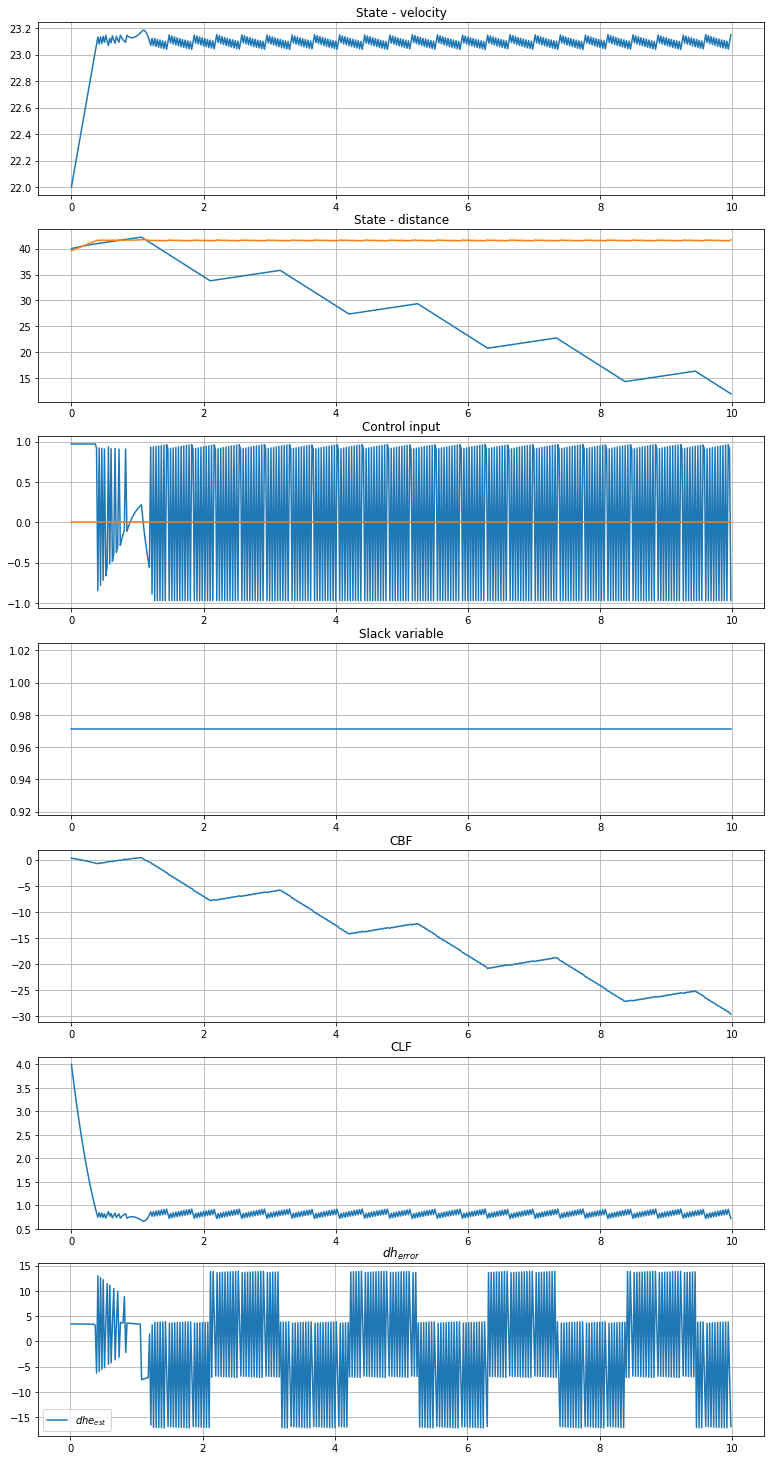

In [8]:
f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

for i in range(laps):
    ax[0].plot(t_lns, np.array(xs_lst)[i,:,1])
    ax[0].grid(True)
    ax[0].set_title('State - velocity')
    
    ax[1].plot(t_lns,  np.array(xs_lst)[i,:,2])
    ax[1].grid(True)
    ax[1].set_title('State - distance')
    
    ax[1].plot(t_lns, Th*np.array(xs)[:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

    ax[2].plot(t_lns,  np.array(us_lst)[i,:])
    ax[2].plot(t_lns,  np.array(u_refs_lst)[i,:])
    ax[2].grid(True)
    ax[2].set_title('Control input')
    

    ax[3].plot(t_lns, np.array(slacks_lst)[i,:])
    ax[3].grid(True)
    ax[3].set_title('Slack variable')
    

    ax[4].plot(t_lns, np.array(hs_lst)[i,:])
    ax[4].grid(True)
    ax[4].set_title('CBF')

    ax[5].plot(t_lns, np.array(Vs_lst)[i,:])
    ax[5].grid(True)
    ax[5].set_title('CLF')

    #ax[6].plot(t_lns[1:], np.array(dhes_lst)[i, 1:])
    ax[6].plot(t_lns[1:], np.array(dhe_reals_lst)[i,1:])
    ax[6].grid(True)
    ax[6].set_title('$dh_{error}$')
    

    #ax[6].set_ylim([-10,10])
    ax[6].legend(['$dhe_{est}$','$dhe_{real}$'])


In [18]:

aac = AAC(m, c_d, f0, f1, f2, v_lead)

v_des = 20

cont = LCBF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_lead, v_des, Th, clf_rate, cbf_rate, p_slack)

weights = 0.2

x_lst = []
u_lst = []
u_ref_lst = []
V_lst = []
h_lst = []
dhe_lst = []
slack_lst = []


x0 = [0,20,39]
x = x0
derivator = Derivator(dt)




xs_lst = []
us_lst = []
u_refs_lst = []
Vs_lst = []
hs_lst = []
dhe_reals_lst = []
dhes_lst = []

slacks_lst = []



# PID control reference
x_dim = 3
u_dim = 1



kp = np.array([[0, 0.15, 0]])
kd = np.array([[0, 1e-3, 0]])
ki = np.array([[0, 5, 0]])


pid = PID(x_dim, u_dim, kp, kd, ki, dt)

laps = 1
pbar = tqdm(total=laps*simTime/dt)

# velocity
#vlaps = np.linspace(18,26, laps)

# distance
#zlaps = np.linspace(28,40, laps)
zlaps = [40]

for z0 in zlaps:
    x0 = [0,22,z0]
    x = x0
    xs = []
    us = []
    u_refs = []
    Vs = []
    hs = []
    dhe_reals = []
    dhes = []

    slacks = []

    for t in np.arange(0, simTime, dt): #simTime
        pbar.update(1)
        # Get reference control
        e = np.array([[0], [v_des], [0]]) - np.expand_dims(x, axis = 1)
        u_ref = pid.update(e) #f0_nom * v**2 + f1_nom * v + f2_nom
        u_ref = u_ref[0,0]

        x_n = aac.update(x, u_ref, t, dt)
        

        xs.append(x)
        u_refs.append(u_ref)

        x = x_n

    u_refs_lst.append(u_refs)
    xs_lst.append(xs)


pbar.close()
    
        
        



100%|██████████| 500/500.0 [00:00<00:00, 697.89it/s]


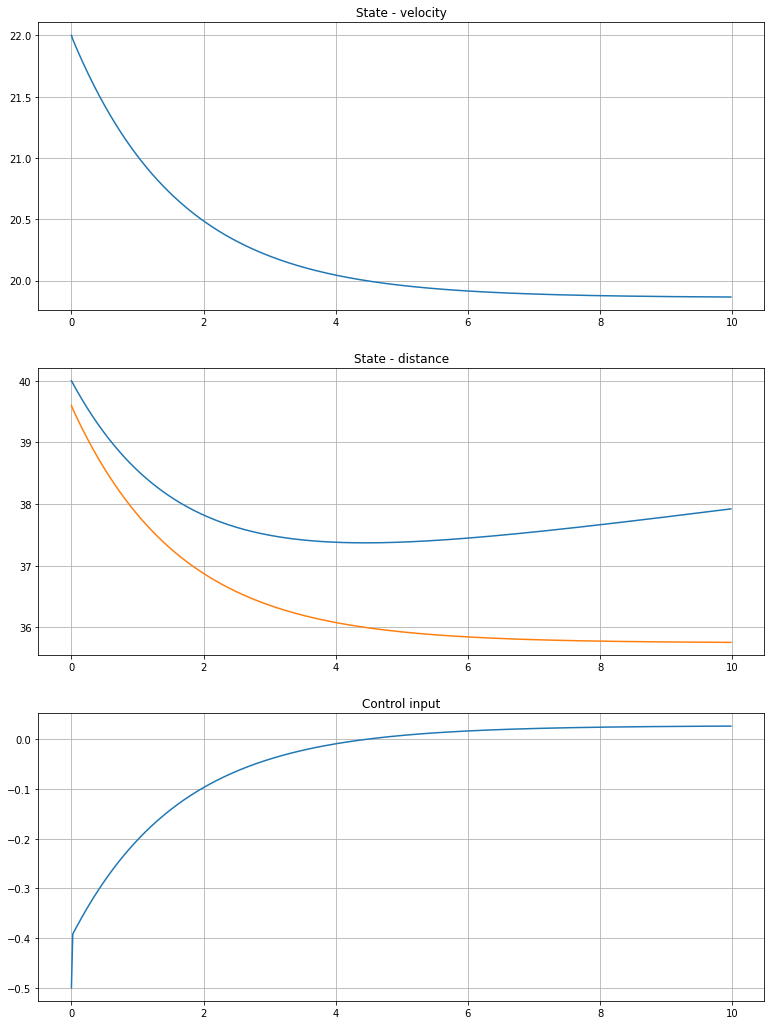

In [19]:
f,ax = plt.subplots(3,1,figsize = (13,18))
t_lns = np.arange(0, simTime, dt)

for i in range(laps):
    ax[0].plot(t_lns, np.array(xs_lst)[i,:,1])
    ax[0].grid(True)
    ax[0].set_title('State - velocity')
    
    ax[1].plot(t_lns,  np.array(xs_lst)[i,:,2])
    ax[1].grid(True)
    ax[1].set_title('State - distance')
    
    ax[1].plot(t_lns, Th*np.array(xs)[:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

    ax[2].plot(t_lns,  np.array(u_refs_lst)[i,:])
    ax[2].grid(True)
    ax[2].set_title('Control input')
